# Static Word Embedding



Glove [Pennington et al., 2014](https://nlp.stanford.edu/pubs/glove.pdf) is a static pre-trained model based on Wikipedia sources. It is static, compared to BERT, in that it is not contextualized to a specific document given. GloVe model is based on the global (referring to statistics of the entire corpus) co-occurrence matrix and moving skip-gram. 

**What is embedding?**
Vector semantics represent a specific word as one point in a multidimensional semantic space. Embeddings are vector representation of words, and often refer to short dense vectors (rather than long sparse vectors with dimensions of $|V|$ as is the case in tf-idf). 

word2vec, for example, uses skip-gram with negative sampling to generate these embeddings (vectors). I am happy to explain more about the algorithm itself, but the intuition here is that the model trains the word prediction by itself by questioning how likely it is for one word to be a neighbor with the target word. 

In this project, I use Glove [Pennington et al., 2014](https://nlp.stanford.edu/pubs/glove.pdf) which takes into account count-based models on top of word2vec features. It is trained on five corpora:  Wikipedia dump with billions of tokens. 

In [2]:

import numpy as np
import pandas as pd
import os
import time
import spacy 
import scipy
from spacy import displacy
import gensim.downloader as api


# Create the output folder if it doesn't exist
output_folder = "../../../output/embedding_static/glove"
os.makedirs(output_folder, exist_ok=True)

start_time = time.time()

# GloVe pre-trained model

I use cosine of the angle between two vectors that correspond to keywords of interest. The cosine is based on the dot product of two vectors, and it increases when two vectors have large values in common. Orthogonal vecotrs will show 0 value for their dot product. Since I'm not interested in the length of vectors, but angle, **cosine similarity metric**, which normalizes dot product by norms of each vector. Hence, $cosine (a, b) = \frac{a \cdot b}{|a||b|}$

In [3]:
# Load the input 
df = pd.read_csv('../../../data/processed/meta.csv')

output_folder = "../../../output/embedding_glove"
os.makedirs(output_folder, exist_ok=True)


In [6]:
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity


# Load embeddings
glove = api.load("glove-wiki-gigaword-100")


speeches = df['text'].tolist()

# Tokenize and filter speechees
speeches = [[word for word in speech.lower().split() if word in glove] for speech in speeches]

# Compute embeddings
embeddings = []
for speech in speeches:
    emb = np.mean([glove[word] for word in speech], axis=0)
    embeddings.append(emb)

# Export embeddings
np.savetxt(os.path.join(output_folder, "static_embedding.csv"), embeddings, delimiter=",")


In [14]:
keywords = [
    "territory", "democracy", "territorial", "liberty", 
    "independence", "colonialism", "human rights", 
    "responsibility", "intervention", "determination"
]
base_keyword = "sovereignty"

if base_keyword in glove.key_to_index:
    base_embedding = glove[base_keyword].reshape(1, -1)

    # Create a function to compute average similarity for a given keyword
    def compute_average_similarity(keyword):
        if keyword in glove.key_to_index:
            keyword_embedding = glove[keyword].reshape(1, -1)
            
            # Compute cosine similarity between base and keyword embeddings for each document
            similarities = df['text'].apply(lambda text: (
                np.mean(cosine_similarity(
                    base_embedding, 
                    np.array([glove[word] for word in text.lower().split() if word in glove.key_to_index and word == keyword])
                ) if any(word in glove.key_to_index and word == keyword for word in text.lower().split()) else np.nan))
            )
            
            # Append the similarities column to df with the keyword as column name
            df[f'similarity_to_{keyword}'] = similarities

    # Compute similarity for each keyword
    for keyword in keywords:
        compute_average_similarity(keyword)


    # Save the output
    output_folder = "../../../output/embedding_glove/"
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, "sovereignty_keywords_cosine.csv")
    df.to_csv(output_path, index=False)
    
    print("Average similarity between 'sovereignty' and other keywords computed and saved successfully.")
else:
    print(f"'{base_keyword}' is not in the vocabulary.")

Average similarity between 'sovereignty' and other keywords computed and saved successfully.


In [12]:
# df.columns. values. tolist()
# new column created!

['ccode_iso',
 'session',
 'year',
 'text',
 'ccode',
 'statenme',
 'gwcode',
 'mid_dispute',
 'mid_num_dispute',
 'cow_num_inter',
 'cow_inter',
 'cow_num_civil',
 'cow_civil',
 'wdi_homicides',
 'wjp_overall',
 'wdi_gdpcapcon2015',
 'wdi_gdpcapgr',
 'wdi_pop',
 'wbgi_rle',
 'wbgi_pve',
 'wbgi_cce',
 'wbgi_gee',
 'pts_ptsa',
 'pts_ptsh',
 'pts_ptss',
 'rsf_pfi',
 'rsf_pfi0212',
 'rsf_pfi1321',
 'bmr_dem',
 'kofgi_dr_eg',
 'kofgi_dr_ig',
 'kofgi_dr_pg',
 'kofgi_dr_sg',
 'nelda_mbbe',
 'nelda_noe',
 'nelda_oa',
 'nelda_rpae',
 'nelda_vcdbe',
 'wdi_log_gdpcapcon2015',
 'wdi_log_pop',
 'mm_num_violence',
 'mm_num_protest',
 'polity',
 'polity2',
 'plty_xrcomp',
 'plty_xropen',
 'plty_xconst',
 'plty_parreg',
 'plty_parcomp',
 'dpi_execrlc',
 'dpi_execnat',
 'dpi_legelec',
 'dpi_exelec',
 'dpi_liec',
 'dpi_eiec',
 'dpi_fraud',
 'dpi_auton',
 'dpi_muni',
 'navco_num_campaign',
 'navco_campaign',
 'dd_regime',
 'dd_democracy',
 'up_num_conflict',
 'up_conflict',
 'up_num_war',
 'up_war',
 'v

# Similarity between keywords over time 

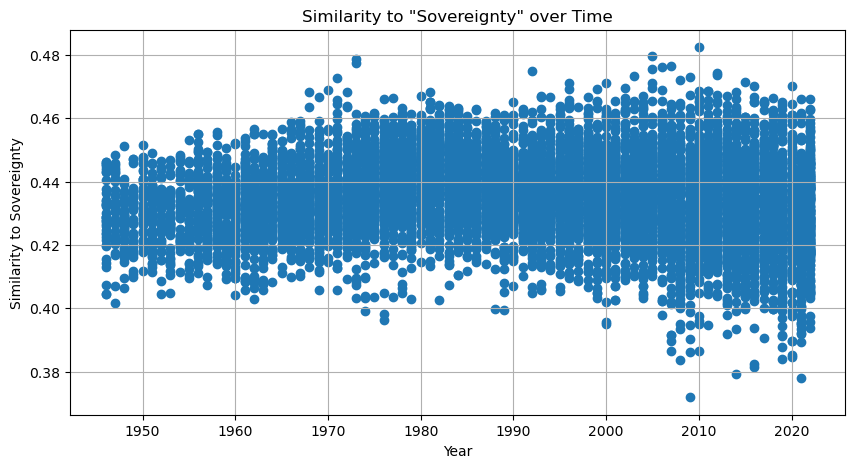

Similarity between 'sovereignty' and 'territory' computed over time and plotted successfully.


In [9]:
import matplotlib.pyplot as plt

keyword1 = "sovereignty"
keyword2 = "territory"

if keyword1 in glove.key_to_index and keyword2 in glove.key_to_index:
    # Plot similarity over time
    plt.figure(figsize=(10, 5))
    plt.scatter(df['year'], df['similarity_to_sovereignty'])
    plt.xlabel('Year')
    plt.ylabel('Similarity to Sovereignty')
    plt.title('Similarity to "Sovereignty" over Time')
    plt.grid(True)
    plt.show()

    print(f"Similarity between '{keyword1}' and '{keyword2}' computed over time and plotted successfully.")
else:
    print("One or both of the keywords are not in the vocabulary.")


# Distance between keywords per regime type

In [8]:
# Checking that there are any rows where dd_democracy is equal to 0
print("Number of rows with dd_democracy equal to 0:", len(df[df['dd_democracy'] == 0]))


Number of rows with dd_democracy equal to 0: 4883


In [10]:
import matplotlib.pyplot as plt
from scipy.stats import linregress  # Import linregress for computing the trend line

keyword1 = "principle_of_sovereignty"
keyword2 = "territory"

if keyword1 in glove.key_to_index and keyword2 in glove.key_to_index:
    embedding1 = glove[keyword1].reshape(1, -1)
    embedding2 = glove[keyword2].reshape(1, -1)

    # Compute cosine similarity between embeddings for each row (speech document)
    distances_democracy = []
    distances_non_democracy = []
    years_non_democracy = []
    for emb, dd_democracy, year in zip(embeddings, df['dd_democracy'], df['year']):
        similarity = cosine_similarity(embedding1, emb.reshape(1, -1))[0][0]
        distance = 1 - similarity
        if dd_democracy == 1:
            distances_democracy.append(distance)
        else:
            distances_non_democracy.append(distance)
            years_non_democracy.append(year)  # Store years for non-democracy distances

    # Plot distance over time for democracy regime with trend line
    plt.figure(figsize=(10, 5))
    plt.scatter(df[df['dd_democracy'] == 1]['year'], distances_democracy, label='Democracy')
    slope_dem, intercept_dem, _, _, _ = linregress(df[df['dd_democracy'] == 1]['year'], distances_democracy)
    trend_line_dem = slope_dem * df[df['dd_democracy'] == 1]['year'] + intercept_dem
    plt.plot(df[df['dd_democracy'] == 1]['year'], trend_line_dem, color='blue', linestyle='--', label='Democracy Trend Line')
    plt.xlabel('Year')
    plt.ylabel('Distance')
    plt.title('Distance between "Territory" and "Sovereignty" over Time (Democracy)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.scatter(years_non_democracy, distances_non_democracy, label='Non-Democracy')
    slope_non_dem, intercept_non_dem, _, _, _ = linregress(years_non_democracy, distances_non_democracy)
    trend_line_non_dem = slope_non_dem * np.array(years_non_democracy) + intercept_non_dem
    plt.plot(years_non_democracy, trend_line_non_dem, color='orange', linestyle='--', label='Non-Democracy Trend Line')
    plt.xlabel('Year')
    plt.ylabel('Distance')
    plt.title('Distance between "Territory" and "Sovereignty" over Time (Non-Democracy)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Distances between '{keyword1}' and '{keyword2}' computed over time and plotted successfully.")
else:
    print("One or both of the keywords are not in the vocabulary.")


One or both of the keywords are not in the vocabulary.


## Additional experiments

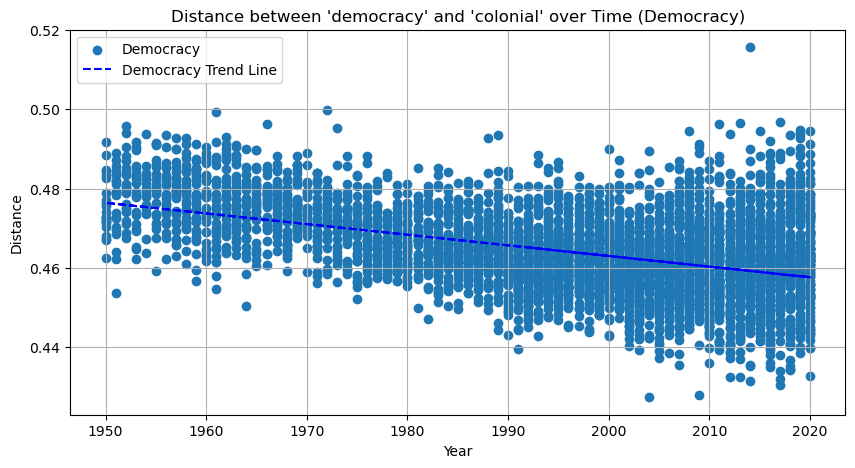

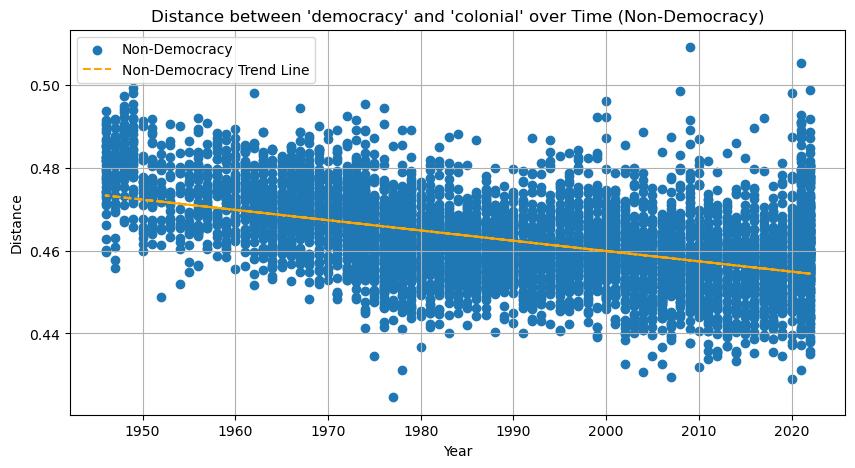

Distances between 'democracy' and 'colonial' computed over time and plotted successfully.


In [61]:
keyword1 = "democracy"
keyword2 = "colonial"

if keyword1 in glove.key_to_index and keyword2 in glove.key_to_index:

    embedding1 = glove[keyword1].reshape(1, -1)
    embedding2 = glove[keyword2].reshape(1, -1)

    distances_democracy = []
    distances_non_democracy = []
    years_non_democracy = []
    for emb, dd_democracy, year in zip(embeddings, df['dd_democracy'], df['year']):
        similarity = cosine_similarity(embedding1, emb.reshape(1, -1))[0][0]
        distance = 1 - similarity
        if dd_democracy == 1:
            distances_democracy.append(distance)
        else:
            distances_non_democracy.append(distance)
            years_non_democracy.append(year) 
            
    plt.figure(figsize=(10, 5))
    plt.scatter(df[df['dd_democracy'] == 1]['year'], distances_democracy, label='Democracy')
    slope_dem, intercept_dem, _, _, _ = linregress(df[df['dd_democracy'] == 1]['year'], distances_democracy)
    trend_line_dem = slope_dem * df[df['dd_democracy'] == 1]['year'] + intercept_dem
    plt.plot(df[df['dd_democracy'] == 1]['year'], trend_line_dem, color='blue', linestyle='--', label='Democracy Trend Line')
    plt.xlabel('Year')
    plt.ylabel('Distance')
    plt.title(f"Distance between '{keyword1}' and '{keyword2}' over Time (Democracy)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.scatter(years_non_democracy, distances_non_democracy, label='Non-Democracy')
    slope_non_dem, intercept_non_dem, _, _, _ = linregress(years_non_democracy, distances_non_democracy)
    trend_line_non_dem = slope_non_dem * np.array(years_non_democracy) + intercept_non_dem
    plt.plot(years_non_democracy, trend_line_non_dem, color='orange', linestyle='--', label='Non-Democracy Trend Line')
    plt.xlabel('Year')
    plt.ylabel('Distance')
    plt.title(f"Distance between '{keyword1}' and '{keyword2}' over Time (Non-Democracy)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Distances between '{keyword1}' and '{keyword2}' computed over time and plotted successfully.")
else:
    print("One or both of the keywords are not in the vocabulary.")


# 6-fold regime type

0. Parliamentary democracy
1. Mixed (semi-presidential) democracy
2. Presidential democracy
3. Civilian dictatorship
4. Military dictatorship
5. Royal dictatorship

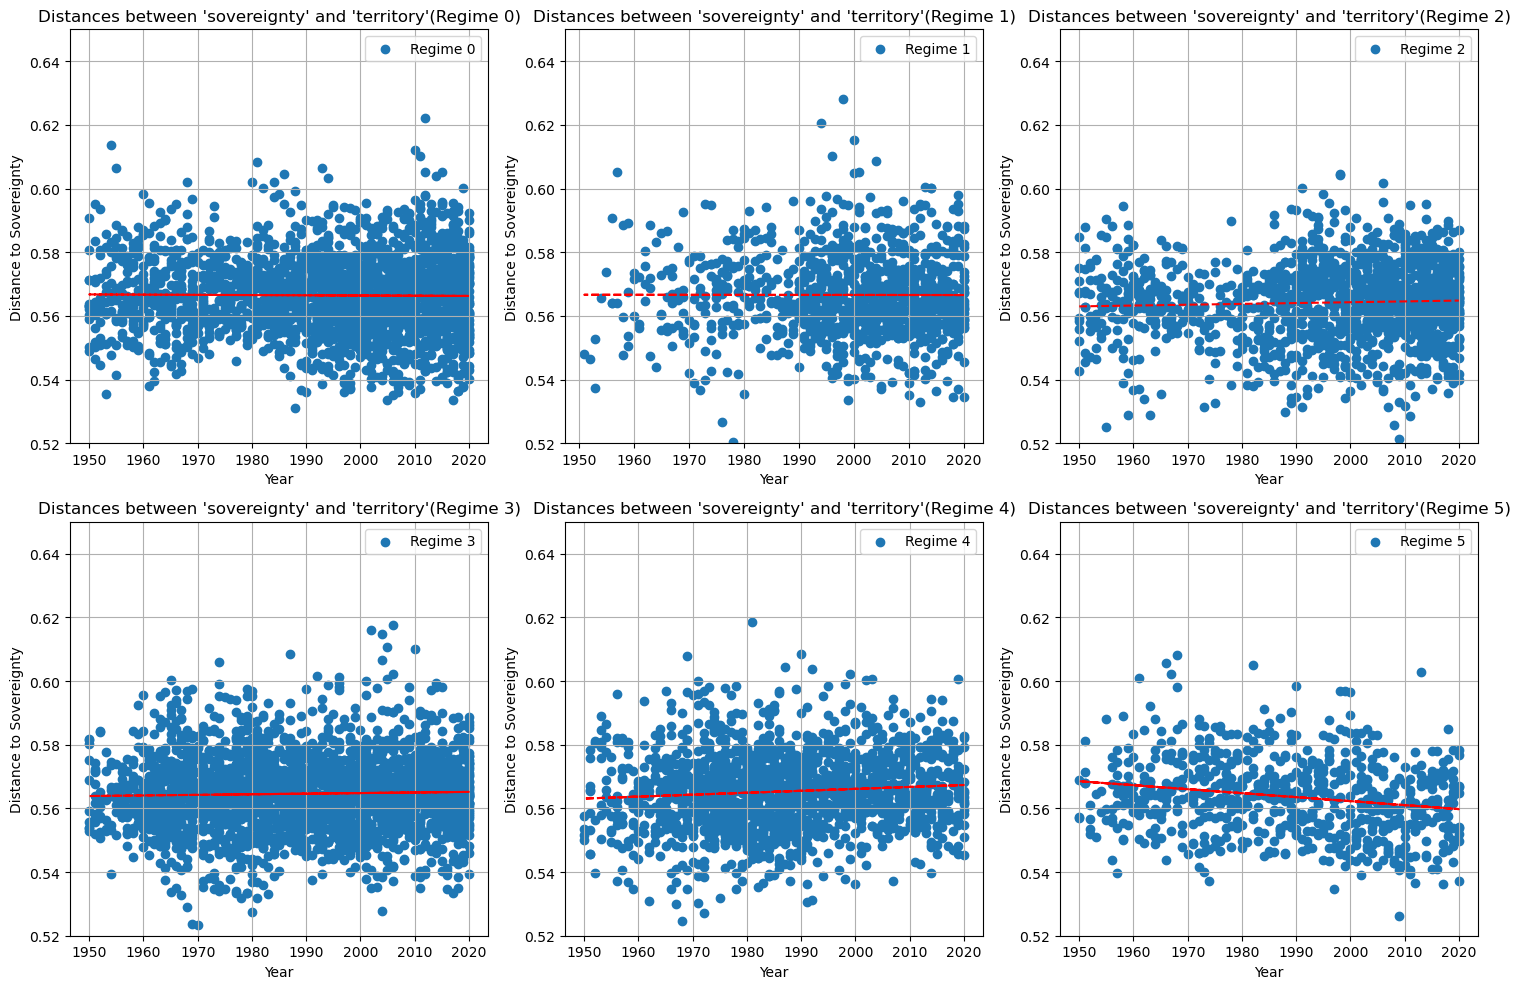

Distances between 'sovereignty' and 'territory' computed over time and plotted successfully.


In [37]:

keyword1 = "sovereignty"
keyword2 = "territory"

if keyword1 in glove.key_to_index and keyword2 in glove.key_to_index:

    embedding1 = glove[keyword1].reshape(1, -1)
    embedding2 = glove[keyword2].reshape(1, -1)

    df_filtered = df.dropna(subset=['dd_regime'])
    df_filtered.loc[:, 'dd_regime'] = df_filtered['dd_regime'].astype(int)

    distances = {i: [] for i in range(6)}
    years = {i: [] for i in range(6)}

    for emb, dd_regime, year in zip(embeddings, df_filtered['dd_regime'], df_filtered['year']):
        similarity = cosine_similarity(embedding1, emb.reshape(1, -1))[0][0]
        distance = 1 - similarity
        distances[dd_regime].append(distance)
        years[dd_regime].append(year)

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten() 
    y_min = 0.52
    y_max = 0.65

    for regime in range(6):
        ax = axs[regime]
        ax.scatter(years[regime], distances[regime], label=f'Regime {regime}')
        if len(distances[regime]) > 1:  # Ensure there are enough data points for trend line computation
            slope, intercept, _, _, _ = linregress(years[regime], distances[regime])
            trend_line = slope * np.array(years[regime]) + intercept
            ax.plot(years[regime], trend_line, linestyle='--', color = 'red')
        ax.set_xlabel('Year')
        ax.set_ylabel('Distance to Sovereignty')
        ax.set_title(f"Distances between '{keyword1}' and '{keyword2}'(Regime {regime})")
        ax.legend()
        ax.set_ylim(y_min,  y_max)
        ax.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    print(f"Distances between '{keyword1}' and '{keyword2}' computed over time and plotted successfully.")
else:
    print("One or both of the keywords are not in the vocabulary.")


In [57]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10568 entries, 0 to 10567
Columns: 111 entries, ccode_iso to similarity_to_sovereignty
dtypes: float32(1), float64(103), int64(2), object(5)
memory usage: 8.9+ MB
None


# Baseline variation across documents

I compute the statistics of the embedding scores (mean and cosine similarity) for each year and plot them as a histogram.

The glove.key_to_index function  maps each unique word to a unique index. If a word appears multiple times in the corpus, it will still be mapped to the same index.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


df = pd.read_csv('../../../data/processed/meta.csv')  # meta data contains country-year variables


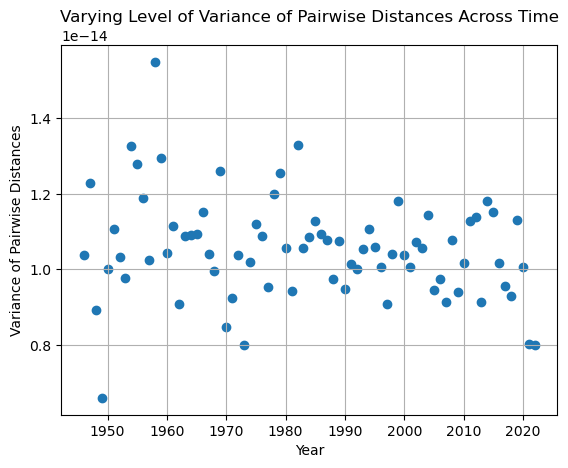

In [59]:
years = []
variances = []

for year in df['year'].unique():
    year_data = df[df['year'] == year]
    similarities = []
    for text in year_data['text']:
        words = text.lower().split()
        emb = np.mean([glove[word] for word in words if word in glove.key_to_index], axis=0)
        emb = emb.reshape(1, -1)
        similarity = cosine_similarity(emb, emb)[0][0]  
        similarities.append(similarity)
    
    variance = np.var(similarities)
    years.append(year)
    variances.append(variance)

plt.scatter(years, variances)
plt.ylabel('Variance of Pairwise Distances')
plt.xlabel('Year')
plt.title('Varying Level of Variance of Pairwise Distances Across Time')
plt.grid(True)
plt.show()


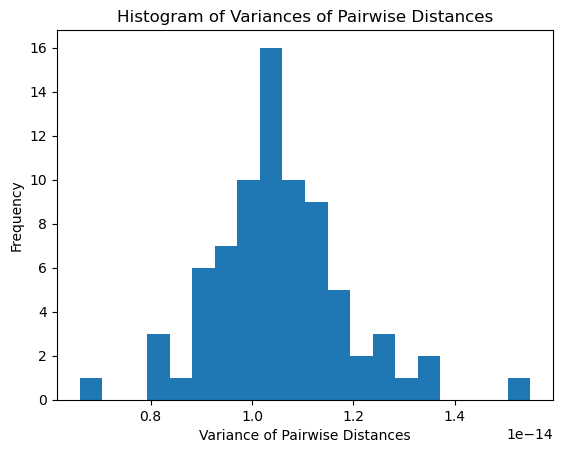

In [12]:

variances = []


for year in df['year'].unique():
    year_data = df[df['year'] == year]
    
    similarities = []
    for text in year_data['text']:
        words = text.lower().split()
        emb = np.mean([glove[word] for word in words if word in glove.key_to_index], axis=0)
        emb = emb.reshape(1, -1)
        similarity = cosine_similarity(emb, emb)[0][0]  # Compare each word to the average embedding of all words
        similarities.append(similarity)
    
    variance = np.var(similarities)
    variances.append(variance)

# Plot histogram of variances
plt.hist(variances, bins=20)
plt.xlabel('Variance of Pairwise Distances')
plt.ylabel('Frequency')
plt.title('Histogram of Variances of Pairwise Distances')
plt.show()

## checking whether the same word gets same numeric embedding value. 

In [18]:

# Check if the word "right" exists in the vocabulary
import gensim.downloader

# Load GloVe embeddings
glove = gensim.downloader.load('glove-wiki-gigaword-300')

if "right" in glove.key_to_index:
    # Get the embedding vector for the word "right"
    embedding_1 = glove["right"]
    print("Embedding vector for the first occurrence of 'right':", embedding_1)

    # Get the embedding vector for another occurrence of the word "right"
    # You can replace the text below with another occurrence of the word "right" in your corpus
    text_with_right = "The right answer is the correct one."
    words_with_right = text_with_right.lower().split()
    embedding_2 = glove["right"]
    print("Embedding vector for another occurrence of 'right':", embedding_2)

    # Check if the embedding vectors are the same
    if (embedding_1 == embedding_2).all():
        print("The embedding vectors for 'right' are the same.")
    else:
        print("The embedding vectors for 'right' are different.")
else:
    print("The word 'right' is not in the vocabulary.")

Embedding vector for the first occurrence of 'right': [ 7.5965e-02 -2.9300e-01 -3.1477e-01  1.3020e-01 -1.2990e-01 -4.8191e-02
 -4.2748e-01 -3.0292e-01 -4.2468e-02 -1.6282e+00 -1.6107e-01 -3.4765e-01
 -5.1817e-02 -2.0463e-01 -1.6552e-01  8.6603e-01 -3.6746e-01  5.8860e-01
  2.4732e-01  4.4265e-01  1.6044e-02  5.0401e-01  6.6919e-01 -6.3785e-01
 -4.5476e-01  2.1259e-01  1.1329e-02 -5.7080e-02 -3.3795e-01  9.9728e-02
  1.2073e-01  3.3822e-01  1.5927e-01 -2.3315e-01 -1.3418e+00 -1.4019e-01
  1.8814e-01 -2.8651e-01 -4.1570e-01  2.8131e-01  2.5345e-01  1.3318e-01
  7.4970e-02 -5.1506e-01 -3.2919e-02 -8.0107e-02  3.9156e-01  6.7576e-02
  4.6271e-02  4.1506e-01 -1.5066e-01 -2.7747e-01  4.1766e-01 -2.8443e-01
 -2.7563e-01 -1.3113e-01  5.1671e-01  2.4617e-03 -1.7877e-01  4.4989e-01
  1.9761e-02 -1.8702e-01 -5.9143e-01  2.1533e-01 -4.1413e-01 -6.2623e-01
  3.7717e-01 -1.0003e-01  1.6393e-01 -6.5906e-02  5.3771e-01 -2.0366e-01
 -1.0336e-01  5.3027e-01  2.6753e-01 -3.6144e-01  1.5471e-01 -4.1722e-

# Statistical Modeling with GloVe Embeddings

To avoid rendering GloVe embeddings from the start, just read in the embedding from the output folder. 

In [ ]:
df = pd.read_csv('../../../output/similarity_over_time') 

from fixedeffect.iv import iv2sls, ivgmm, ivtest
from fixedeffect.fe import fixedeffect, did, getfe
from fixedeffect.utils.panel_dgp import gen_data

